Synthesis sound

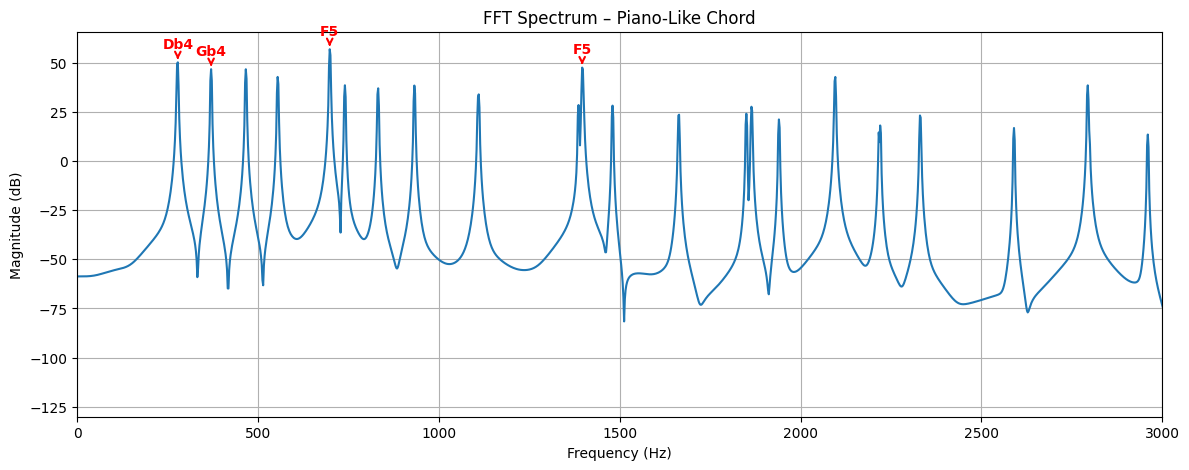

In [13]:
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

sample_rate = 44100
duration = 4.0
master_amp = 0.6

# Chord: F5, Bb4, Gb4, Db4
frequencies = [698.46, 466.16, 369.99, 277.18]
note_names = ["F5", "Bb4", "Gb4", "Db4"]
note_amps = [1.0, 0.3, 0.3, 0.5]

def piano_envelope(t, attack=0.01, decay=3.5):
    env = np.zeros_like(t)
    a = int(attack * sample_rate)
    env[:a] = np.linspace(0, 1, a)
    env[a:] = np.exp(-3 * (t[a:] - attack))
    return env

t = np.arange(0, duration, 1 / sample_rate)
signal = np.zeros_like(t)

for f, note_amp in zip(frequencies, note_amps):
    note = np.zeros_like(t)

    # Harmonics (piano-like)
    for h in range(1, 9):
        harmonic_amp = (1 / h) * np.exp(-0.25 * h)
        note += harmonic_amp * np.sin(2 * np.pi * f * h * t)

    note *= piano_envelope(t)
    signal += note_amp * note

# Normalize & scale
signal /= np.max(np.abs(signal))
signal *= master_amp
sd.play(signal, sample_rate)
sd.wait()

fft_duration = 0.5  # seconds
N = int(sample_rate * fft_duration)

fft_signal = signal[:N]
window = np.hanning(N)
fft_signal *= window

fft_result = np.fft.rfft(fft_signal)
fft_mag = np.abs(fft_result)
fft_freqs = np.fft.rfftfreq(N, 1 / sample_rate)

# Convert to dB
fft_db = 20 * np.log10(fft_mag + 1e-12)

# Find peaks in the spectrum
peaks, _ = find_peaks(fft_db, height=0, distance=20)
peak_freqs = fft_freqs[peaks]
peak_mags = fft_db[peaks]

# Sort by magnitude and get top peaks
top_peaks_idx = np.argsort(peak_mags)[-len(frequencies):]
top_peaks_freqs = peak_freqs[top_peaks_idx]
top_peaks_mags = peak_mags[top_peaks_idx]

plt.figure(figsize=(14, 5))
plt.plot(fft_freqs, fft_db, label="FFT Magnitude")

# Annotate peaks with note names (sorted by frequency)
for freq, mag in zip(top_peaks_freqs, top_peaks_mags):
    # Find closest note frequency
    closest_idx = np.argmin(np.abs(np.array(frequencies) - freq))
    note_name = note_names[closest_idx]
    plt.annotate(note_name, xy=(freq, mag), xytext=(0, 10), 
                textcoords="offset points", ha="center", fontsize=10, 
                fontweight="bold", color="red",
                arrowprops=dict(arrowstyle="->", color="red", lw=1.5))

plt.xlim(0, 3000)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("FFT Spectrum – Piano-Like Chord")
plt.grid(True)
plt.show()
